## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

**QUESTION:** Load dataset and display some lines of the csv file.

In [33]:
# Define the file path to the dataset
dataset_path = "ai4i2020.csv"

# Load the dataset into a pandas DataFrame
data = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

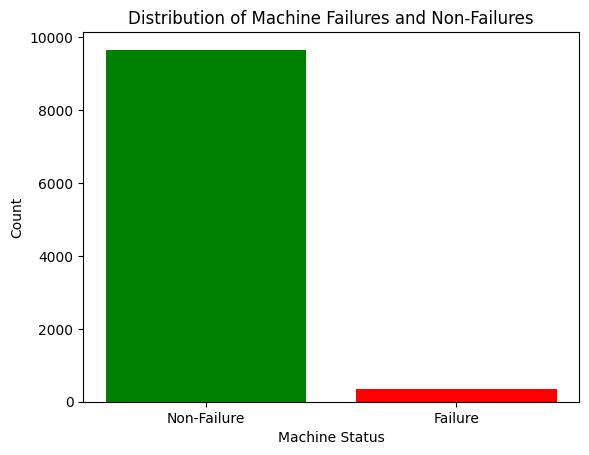

In [34]:
# Count the occurrences of failures and non-failures
failure_counts = data['Machine failure'].value_counts()

# Plot the bar graph
plt.bar(failure_counts.index, failure_counts.values, color=['green', 'red'])
plt.xticks(ticks=[0, 1], labels=['Non-Failure', 'Failure'])
plt.xlabel('Machine Status')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

There are a lot more exemples of non-failure thant Failures in the dataset.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

I could be difficult to train the model to recognize the failures because there is not enough data for it.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

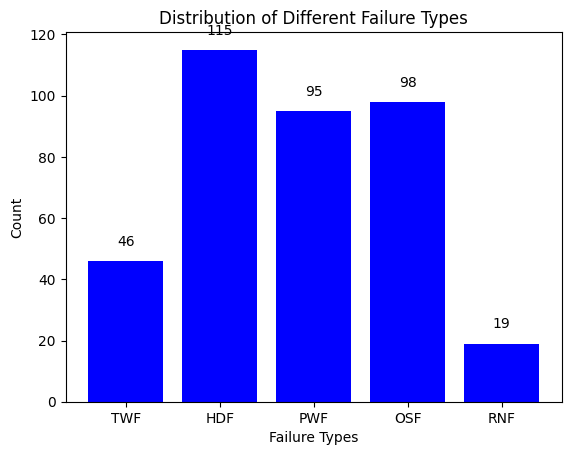

In [35]:
# Count the occurrences of each failure type
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = data[failure_types].sum()

# Plot the bar chart
plt.bar(failure_counts.index, failure_counts.values, color='blue')

# Add exact values above each bar
for index, value in enumerate(failure_counts.values):
    plt.text(index, value + 5, str(value), ha='center', fontsize=10)

plt.xlabel('Failure Types')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

There are less "Tool Wear Failure" than other types of failures so the model could be biaised against recognizing this type of failures.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

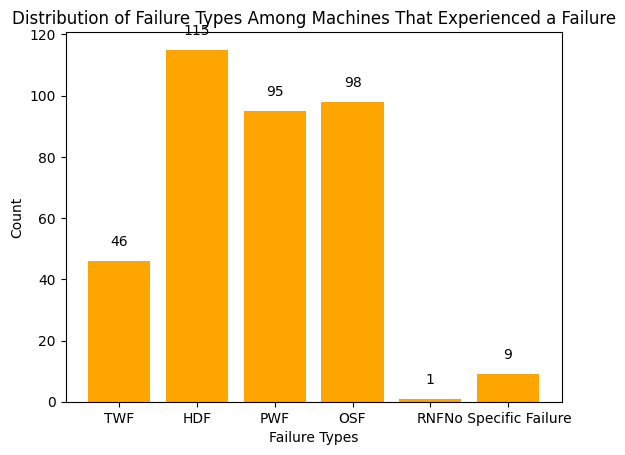

In [36]:
# Filter the dataset for machines that experienced a failure
failed_machines = data[data['Machine failure'] == 1]

# Count the occurrences of each failure type
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = failed_machines[failure_types].sum()

# Add a "No Specific Failure" category
no_specific_failure = (failed_machines[failure_types].sum(axis=1) == 0).sum()
failure_counts['No Specific Failure'] = no_specific_failure

# Plot the bar chart
plt.bar(failure_counts.index, failure_counts.values, color='orange')

# Add exact values above each bar
for index, value in enumerate(failure_counts.values):
    plt.text(index, value + 5, str(value), ha='center', fontsize=10)

plt.xlabel('Failure Types')
plt.ylabel('Count')
plt.title('Distribution of Failure Types Among Machines That Experienced a Failure')
plt.show()

**ANALYSIS QUESTION:** What do you obsrve compared to the previous question ? What can you conclude?

Compared to the previous question, we observe that among machines that experienced a failure, there are cases where no specific failure type was recorded ("No Specific Failure" category). This indicates that while the machine failed, the failure could not be attributed to any of the predefined failure types (TWF, HDF, PWF, OSF, RNF). This could mean we need to do some kind of data cleaning.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [37]:
data.dtypes

UDI                          int64
Product ID                     str
Type                           str
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

To train the model, the following columns will be used:

Inputs:
- Air temperature [K]
- Process temperature [K]
- Rotational speed [rpm]
- Torque [Nm]
- Tool wear [min]

These columns represent the sensor readings and operational conditions of the machine, which are critical for predicting failures.

Outputs:
- Machine failure: This column will be used to predict whether the machine will fail (binary classification).
- TWF, HDF, PWF, OSF, RNF: These columns will be used to predict the specific type of failure (multi-label classification).

Justification:
- The input columns are directly related to the operational state of the machine and are likely to influence the occurrence of failures.
- The output columns align with the goal of predicting both the occurrence of a failure and its specific type, as required for predictive maintenance.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [38]:
# Define the input features (X) and output labels (Y)
X = data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].values
Y = data[['TWF', 'HDF', 'PWF', 'OSF']].values
failure = data['Machine failure'].values
no_specific_failure = ((failure == 1) & (Y.sum(axis=1) == 0)).astype(int)
no_failure = (failure == 0).astype(int)

# Combine all labels
Y = np.column_stack((Y, no_specific_failure, no_failure))

# Convert the data to TensorFlow datasets
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

# Shuffle and split the dataset
train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size).shuffle(buffer_size=train_size, seed=42)
test_dataset = dataset.skip(train_size)

# Batch the datasets
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

# Print the sizes of the datasets
print("Number of batches in train_dataset:", len(list(train_dataset)))
print("Number of batches in test_dataset:", len(list(test_dataset)))

Number of batches in train_dataset: 250
Number of batches in test_dataset: 63


**QUESTION** Code below the model architecture

In [39]:
# Initialize the model
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dropout(0.2),

    # Hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Output layer (6 outputs for multi-label classification)
    tf.keras.layers.Dense(6, activation='sigmoid')
])

c:\Users\heris\Documents\STM32\IA_embarquee\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8759 - loss: 4.3319 - val_accuracy: 0.9805 - val_loss: 0.5089
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9366 - loss: 0.8980 - val_accuracy: 0.9805 - val_loss: 0.0723
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9454 - loss: 0.3053 - val_accuracy: 0.9805 - val_loss: 0.0617
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9557 - loss: 0.1682 - val_accuracy: 0.9805 - val_loss: 0.0482
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9595 - loss: 0.1309 - val_accuracy: 0.9805 - val_loss: 0.0472
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9613 - loss: 0.1114 - val_accuracy: 0.9805 - val_loss: 0.0441
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9613 - loss: 0.0955 - val_accuracy: 0.9805 - val_loss: 0.0486
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9620 - loss: 0.0931 - val_accuracy: 0.

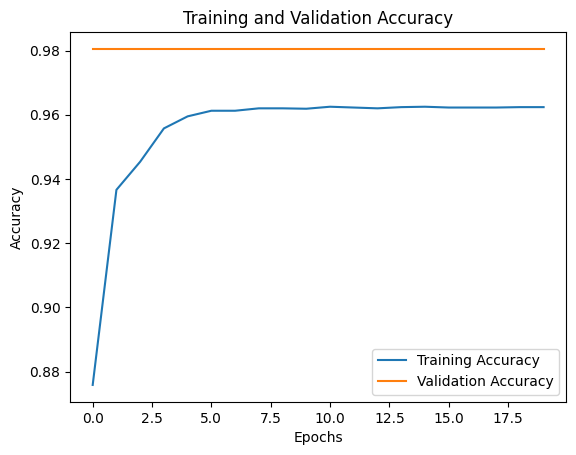

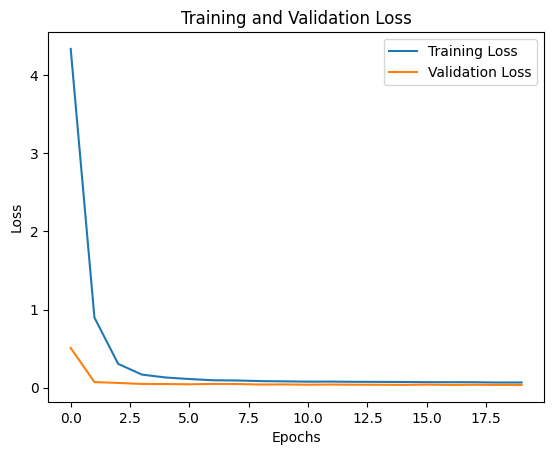

In [40]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    verbose=1
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

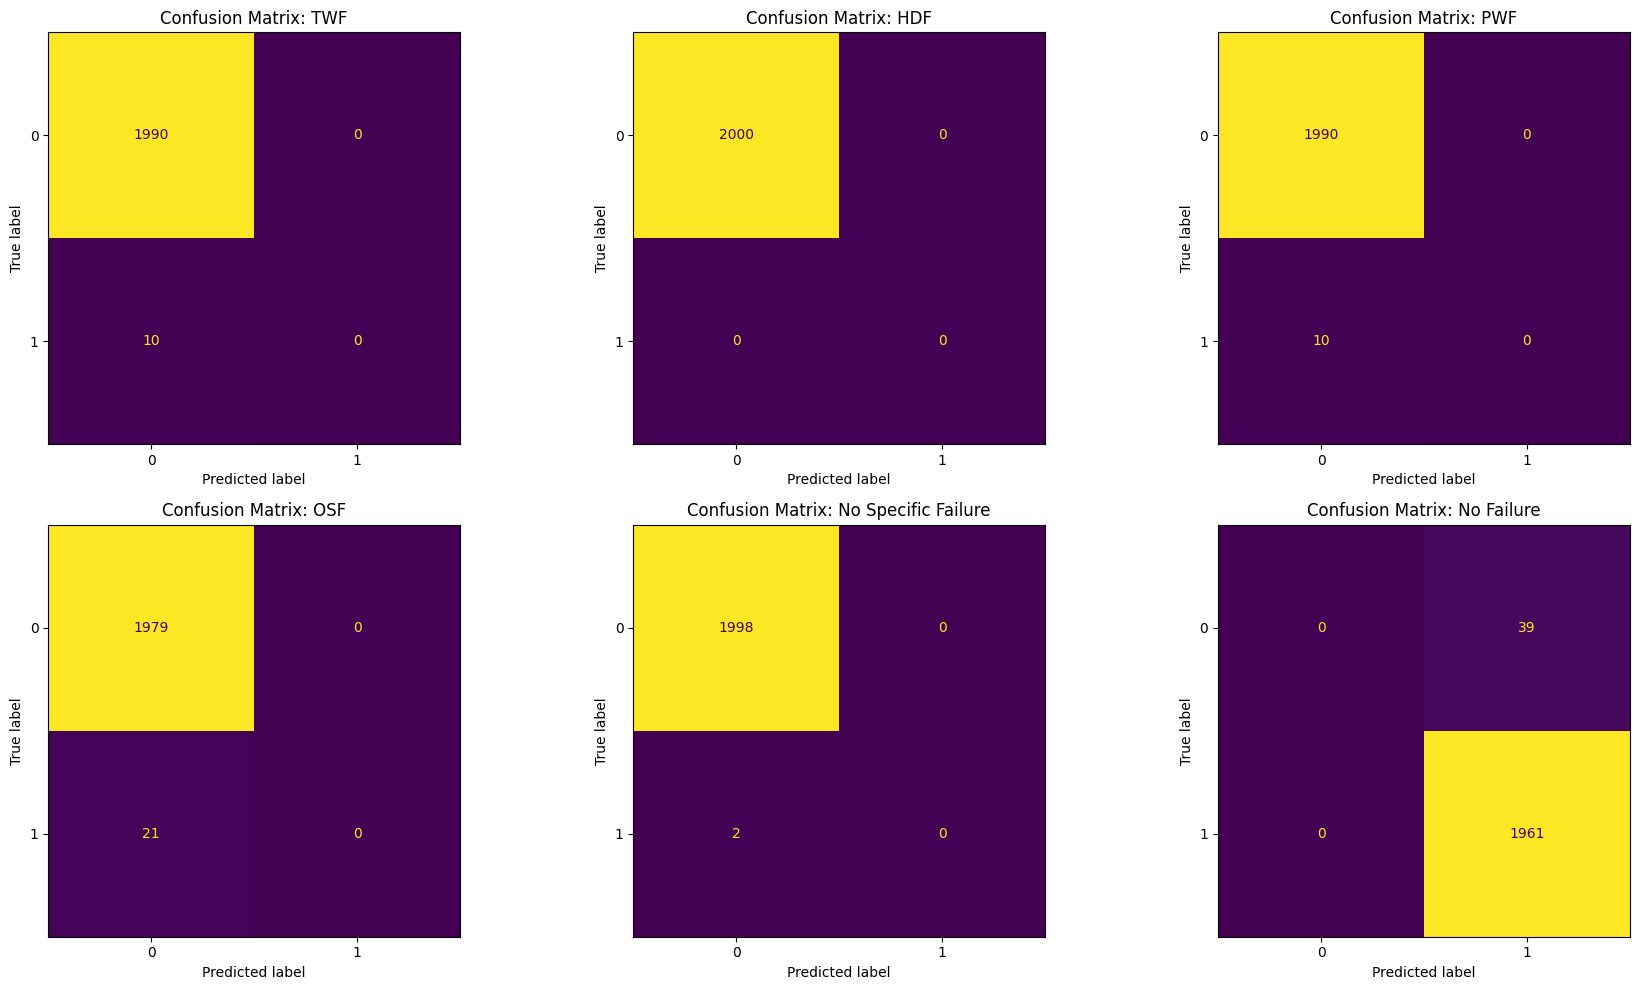

                     precision    recall  f1-score   support

                TWF       0.00      0.00      0.00        10
                HDF       0.00      0.00      0.00         0
                PWF       0.00      0.00      0.00        10
                OSF       0.00      0.00      0.00        21
No Specific Failure       0.00      0.00      0.00         2
         No Failure       0.98      1.00      0.99      1961

          micro avg       0.98      0.98      0.98      2004
          macro avg       0.16      0.17      0.17      2004
       weighted avg       0.96      0.98      0.97      2004
        samples avg       0.98      0.98      0.98      2004



c:\Users\heris\Documents\STM32\IA_embarquee\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\heris\Documents\STM32\IA_embarquee\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\heris\Documents\STM32\IA_embarquee\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [41]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions from the test dataset
y_true = []
y_pred = []
for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch)
    y_true.append(y_batch.numpy())
    y_pred.append((preds > 0.5).astype(int))

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

# Plot confusion matrices for each label
labels = ['TWF', 'HDF', 'PWF', 'OSF', 'No Specific Failure', 'No Failure']
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, (cm, label) in enumerate(zip(conf_matrices, labels)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f'Confusion Matrix: {label}')
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels))

**ANALYSIS QUESTION** What do you observe? What can you conclude?

We observe we don't predict any kind of failures despite our high accuracy. That's because the dataset is biaised against detecting failures and so the trained model always says there are failures.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [42]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Filter the dataset to remove RNF data and unspecified failures
filtered_data = data[(data['RNF'] == 0) & ((data['Machine failure'] == 0) | (data[['TWF', 'HDF', 'PWF', 'OSF']].sum(axis=1) > 0))]

# 1. Create a single multiclass target column
label_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'No Failure']
filtered_data['No Failure'] = (filtered_data['Machine failure'] == 0).astype(int)
y_multiclass = filtered_data[label_cols].idxmax(axis=1)

X = filtered_data[['Air temperature [K]', 'Process temperature [K]', 
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].values
y = y_multiclass.values

# 2. Split (use stratify to keep class proportions balanced in the split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Calculate counts correctly now that y_train is 1D
counts = Counter(y_train)
total_failures = sum(v for k, v in counts.items() if k != 'No Failure')

# 4. Define Resampling
under = RandomUnderSampler(
    sampling_strategy={'No Failure': total_failures}, 
    random_state=42
)

over = SMOTE(random_state=42)

resampling_pipeline = Pipeline([
    ('undersample_majority', under),
    ('oversample_minorities', over)
])

# 5. Fit Resample
X_train_balanced, y_train_balanced = resampling_pipeline.fit_resample(X_train, y_train)

print(f"Balanced distribution: {Counter(y_train_balanced)}")

Balanced distribution: Counter({'HDF': 263, 'No Failure': 263, 'OSF': 263, 'PWF': 263, 'TWF': 263})


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

We create a pipeline using imblearn to undersample the majority class (No failures) then oversample the minority classe (all failure types) to keep the number of data manageable and make it so that every output is balanced and the dataset is not balanced anymore.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [50]:
# Initialize the model
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Dense(256, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dropout(0.2),

    # Hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Output layer (5 outputs for multi-label classification)
    tf.keras.layers.Dense(5, activation='sigmoid')
])

c:\Users\heris\Documents\STM32\IA_embarquee\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**QUESTION** Code below the algorithms allowing to train model


Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2715 - loss: 7.6148 - val_accuracy: 0.0125 - val_loss: 0.6836
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2304 - loss: 0.7633 - val_accuracy: 0.0080 - val_loss: 0.6406
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2259 - loss: 0.6620 - val_accuracy: 0.0080 - val_loss: 0.6071
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2319 - loss: 0.6001 - val_accuracy: 0.9679 - val_loss: 0.3959
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2365 - loss: 0.5420 - val_accuracy: 0.8612 - val_loss: 0.4523
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2297 - loss: 0.5242 - val_accuracy: 0.9414 - val_loss: 0.4454
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2608 - loss: 0.4989 - val_accuracy: 0.0145 - val_loss: 0.5102
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2540 - loss: 0.4986 - val_accuracy: 0.

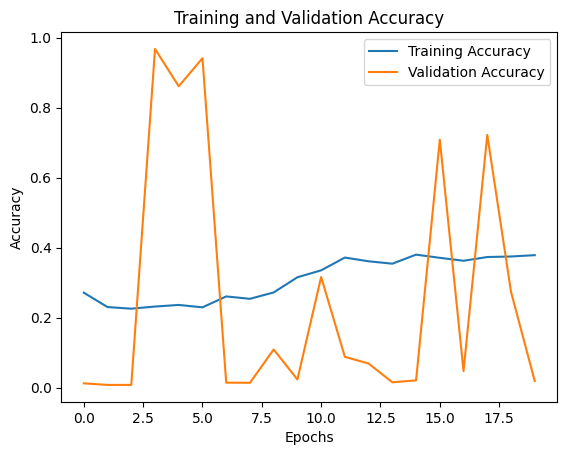

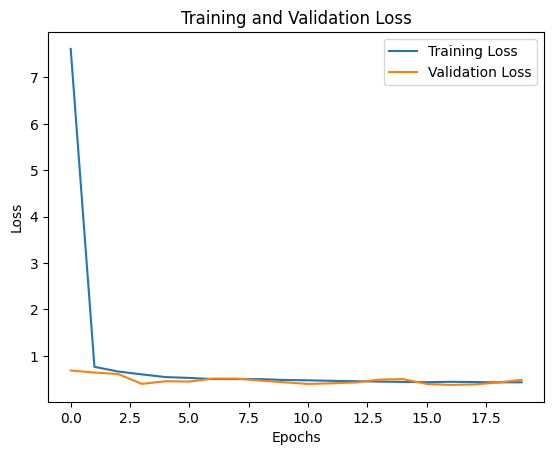

In [51]:
from sklearn.preprocessing import LabelEncoder

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_balanced)
y_test_encoded = le.transform(y_test)
num_classes = len(le.classes_)

# One-hot encode the labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# Train the model
history = model.fit(
    X_train_balanced,  # Use the balanced features
    y_train_one_hot,   # Use the one-hot encoded labels
    validation_data=(X_test, y_test_one_hot),
    epochs=20,
    batch_size=8,
    verbose=1
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


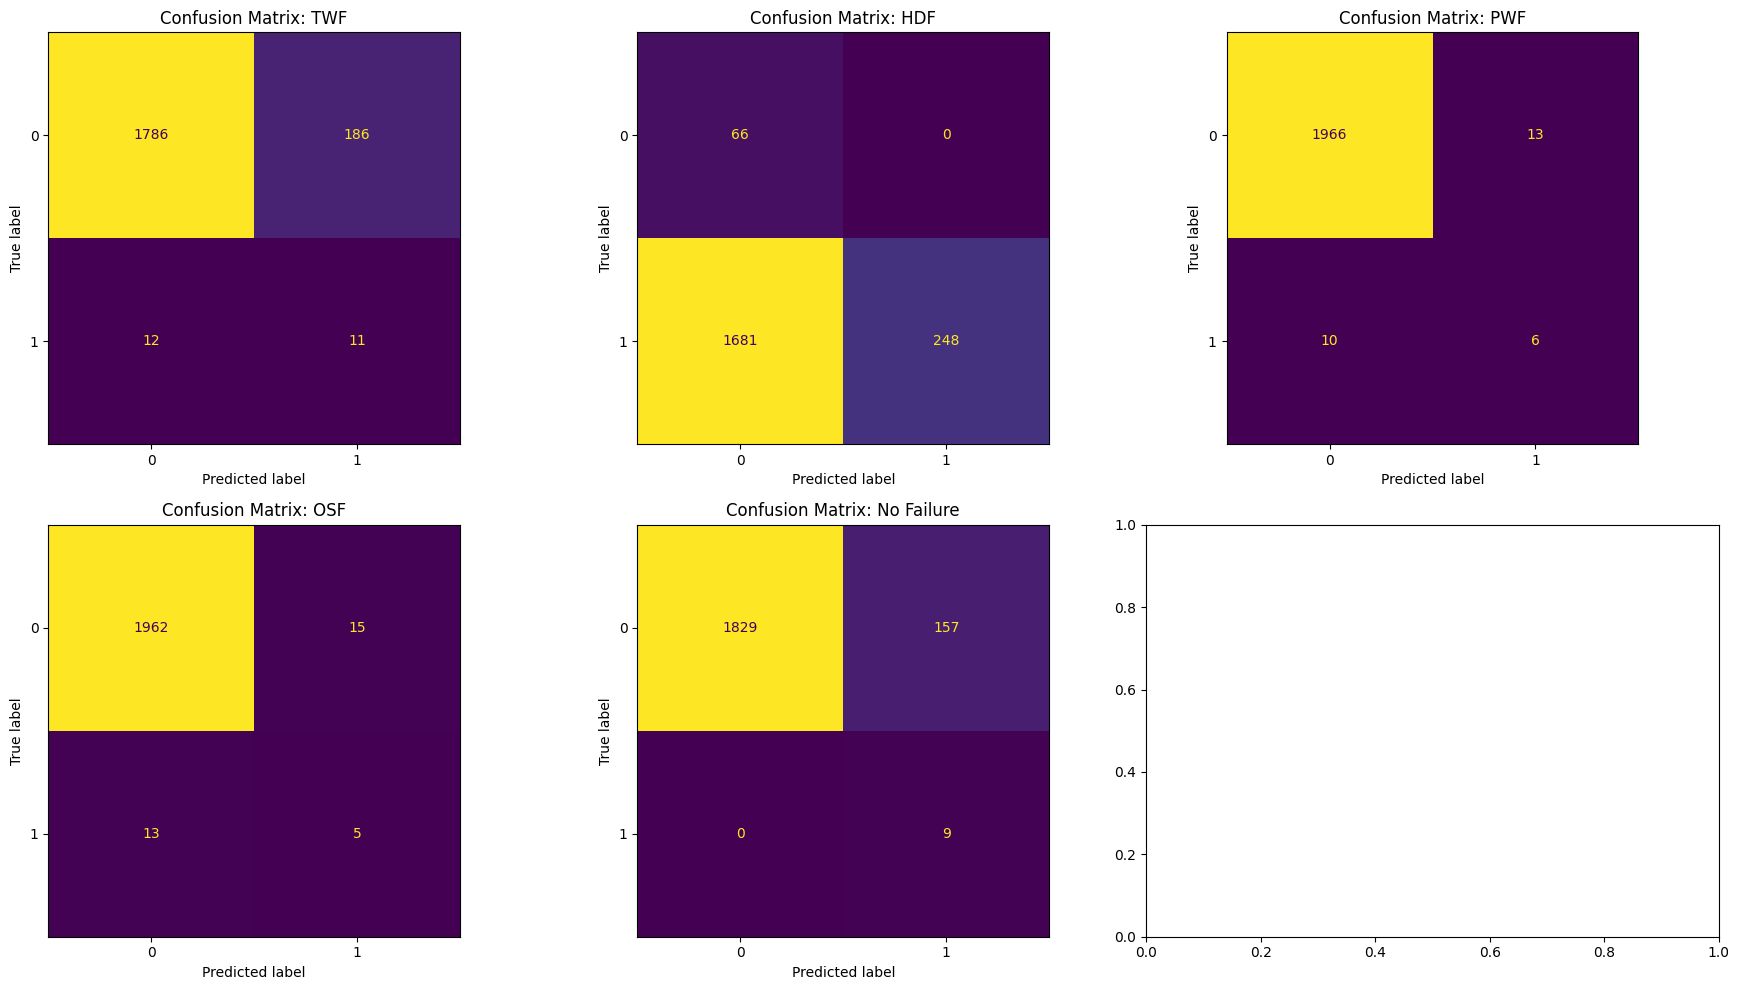

              precision    recall  f1-score   support

         TWF       0.06      0.48      0.10        23
         HDF       1.00      0.13      0.23      1929
         PWF       0.32      0.38      0.34        16
         OSF       0.25      0.28      0.26        18
  No Failure       0.05      1.00      0.10         9

   micro avg       0.43      0.14      0.21      1995
   macro avg       0.34      0.45      0.21      1995
weighted avg       0.97      0.14      0.23      1995
 samples avg       0.14      0.14      0.14      1995



c:\Users\heris\Documents\STM32\IA_embarquee\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [49]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

# Use X_test and y_test for evaluation
lb = LabelBinarizer()
y_true = lb.fit_transform(y_test)  # One-hot encode y_test
preds = model.predict(X_test)
y_pred = (preds > 0.5).astype(int)

# Plot confusion matrices for each label
labels = ['TWF', 'HDF', 'PWF', 'OSF', 'No Failure']
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, (cm, label) in enumerate(zip(conf_matrices, labels)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f'Confusion Matrix: {label}')
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels))

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"